In [1]:
# clone the repo
!git clone --recursive https://github.com/ApurvaBhargava/pytorch-classification
# switch to repo's directory
import os
os.chdir('pytorch-classification')
os.getcwd()

Cloning into 'pytorch-classification'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 332 (delta 9), reused 36 (delta 6), pack-reused 287
Receiving objects: 100% (332/332), 88.37 MiB | 9.77 MiB/s, done.
Resolving deltas: 100% (176/176), done.
Submodule 'utils/progress' (https://github.com/verigak/progress.git) registered for path 'utils/progress'
Cloning into '/content/pytorch-classification/utils/progress'...
remote: Enumerating objects: 306, done.        
remote: Counting objects: 100% (42/42), done.        
remote: Compressing objects: 100% (31/31), done.        
remote: Total 306 (delta 19), reused 28 (delta 11), pack-reused 264        
Receiving objects: 100% (306/306), 662.72 KiB | 20.08 MiB/s, done.
Resolving deltas: 100% (176/176), done.
Submodule path 'utils/progress': checked out '715a2e130f14fa95c092c771813fb1c729dae333'


'/content/pytorch-classification'

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import torch
import models.cifar as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
from torch.nn import Softmax
import cv2
from collections import defaultdict
import pandas as pd
from scipy.stats import entropy
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
# Load and transform the test data

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataloader = datasets.CIFAR100
num_classes = 100

testset = dataloader(root='./data', train=False, download=True, transform=transform_test)
testloader = data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Get class names
class_names = testset.classes


Extracting ./data/cifar-100-python.tar.gz to ./data


In [4]:
# Get model blueprint and load from checkpoint
model = models.__dict__['densenet'](
                    num_classes=100,
                    depth=100,
                    growthRate=12,
                    compressionRate=2,
                    dropRate=0,
                )
model = torch.nn.DataParallel(model).cuda()
checkpoint = torch.load('/content/pytorch-classification/checkpoints/cifar100/densenet-bc-100-12/model_best.pth.tar')
best_acc = checkpoint['best_acc']
print('Validation accuracy: ' + str(best_acc.item()))
model.load_state_dict(checkpoint['state_dict'])

# Get targets and outputs
output_list = []
target_list = []
softmax = Softmax(dim=1)
model.eval()
for batch_idx, (inputs, targets) in enumerate(testloader):
  inputs, targets = inputs.cuda(), targets.cuda()
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)
  # compute output
  outputs = softmax(model(inputs)).detach().cpu().numpy()
  outputs = np.argmax(outputs, axis=1)
  output_list.extend(outputs)
  target_list.extend(targets.detach().cpu().numpy())
print('Correct out of 10000: '+str((np.array(output_list)==np.array(target_list)).sum()))

Validation accuracy: 77.0999984741211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Correct out of 10000: 7710


## Additive noise

In [33]:
output_list_dict = defaultdict(list)
target_list_dict = defaultdict(list)
p_ones_list = [0, 0.15, 0.25, 0.35, 0.45]
for p_ones in p_ones_list:
  # Get model blueprint and load from checkpoint
  model = models.__dict__['densenet'](
                      num_classes=100,
                      depth=100,
                      growthRate=12,
                      compressionRate=2,
                      dropRate=0,
                  )
  model = torch.nn.DataParallel(model).cuda()
  checkpoint = torch.load('/content/pytorch-classification/checkpoints/cifar100/densenet-bc-100-12/model_best.pth.tar')
  model.load_state_dict(checkpoint['state_dict'])

  with torch.no_grad():
    for name, param in model.named_parameters():
      if 'conv' in name:
        noise = torch.randn(param.size()) * 0.1
        mask = torch.tensor(np.random.binomial(n=1, p=p_ones, size=param.size()))
        noise = torch.mul(noise, mask).cuda()
        param.add_(noise)
    # Get targets and outputs
    output_list = []
    target_list = []
    softmax = Softmax(dim=1)
    model.eval()
    for batch_idx, (inputs, targets) in enumerate(testloader):
      inputs, targets = inputs.cuda(), targets.cuda()
      inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)
      # compute output
      outputs = softmax(model(inputs)).detach().cpu().numpy()
      outputs = np.argmax(outputs, axis=1)
      output_list.extend(outputs)
      target_list.extend(targets.detach().cpu().numpy())
    print('Correct out of 10000: '+str((np.array(output_list)==np.array(target_list)).sum()))
    output_list_dict[p_ones] = output_list
    target_list_dict[p_ones] = target_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Correct out of 10000: 7710
Correct out of 10000: 6417
Correct out of 10000: 5595
Correct out of 10000: 4858
Correct out of 10000: 3352


In [34]:
aquatic, plants, animals, people, transport = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
for p_ones in p_ones_list:

  output_list = output_list_dict[p_ones]
  target_list = target_list_dict[p_ones]

  # water organisms
  small_fish = [class_names.index(x) for x in ['aquarium_fish', 'trout', 'flatfish']]
  big_fish_mammal = [class_names.index(x) for x in ['dolphin', 'whale', 'shark', 'ray']]
  aquatic_mammal = [class_names.index(x) for x in ['beaver', 'seal', 'otter']]
  all_aquatic_life = small_fish + big_fish_mammal + aquatic_mammal

  class_wrong, class_general, class_med, class_specific = 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in all_aquatic_life:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in small_fish and output_list[i] in small_fish) or \
      (target_list[i] in big_fish_mammal and output_list[i] in big_fish_mammal) or \
      (target_list[i] in aquatic_mammal and output_list[i] in aquatic_mammal):
        class_med += 1
      elif output_list[i] in all_aquatic_life:
        class_general += 1
      else:
        class_wrong += 1
  aquatic[p_ones] = [class_wrong, class_general, class_med, class_specific]

  # nonmoving living things
  flowers = [class_names.index(x) for x in ['orchid', 'poppy', 'rose', 'sunflower', 'tulip']]
  trees = [class_names.index(x+'_tree') for x in ['maple', 'oak', 'palm', 'pine', 'willow']]+[class_names.index('forest')]
  living_nonmoving = flowers + trees

  class_wrong, class_general, class_med, class_specific = 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in living_nonmoving:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in flowers and output_list[i] in flowers) or \
      (target_list[i] in trees and output_list[i] in trees):
        class_med += 1
      elif output_list[i] in living_nonmoving:
        class_general += 1
      else:
        class_wrong += 1
  plants[p_ones] = [class_wrong, class_general, class_med, class_specific]

  # moving livin things
  large_carniomni = [class_names.index(x) for x in ['bear', 'leopard', 'lion', 'tiger', 'wolf', 'fox']]
  #large_herbiomni = [class_names.index(x) for x in ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']]
  small_animals = [class_names.index(x) for x in ['porcupine', 'possum', 'raccoon', 'skunk', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']]
  reptiles = [class_names.index(x) for x in ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']]
  insects = [class_names.index(x) for x in ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']]
  non_insect_invertebrates = [class_names.index(x) for x in ['crab', 'lobster', 'snail', 'spider', 'worm']]
  animals_all = large_carniomni+small_animals+reptiles
  creatures_all = insects+non_insect_invertebrates
  living_moving = animals_all+creatures_all

  class_wrong, class_general, class_med, class_subspecific, class_specific = 0, 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in living_moving:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in large_carniomni and output_list[i] in large_carniomni) or \
      (target_list[i] in small_animals and output_list[i] in small_animals) or \
      (target_list[i] in reptiles and output_list[i] in reptiles) or \
      (target_list[i] in insects and output_list[i] in insects) or \
      (target_list[i] in non_insect_invertebrates and output_list[i] in non_insect_invertebrates):
        class_subspecific += 1
      elif (target_list[i] in animals_all and output_list[i] in animals_all) or \
      (target_list[i] in creatures_all and output_list[i] in creatures_all):
        class_med += 1
      elif output_list[i] in living_moving:
        class_general += 1
      else:
        class_wrong += 1
  animals[p_ones] = [class_wrong, class_general, class_med, class_subspecific, class_specific]

  # humans
  man_boy = [class_names.index(x) for x in ['man', 'woman']]
  woman_girl = [class_names.index(x) for x in ['boy', 'girl']]
  babies = [class_names.index(x) for x in ['baby']]
  humans = man_boy + woman_girl + babies

  class_wrong, class_general, class_med, class_specific = 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in humans:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in man_boy and output_list[i] in man_boy) or \
      (target_list[i] in woman_girl and output_list[i] in woman_girl) or \
      (target_list[i] in babies and output_list[i] in babies):
        class_med += 1
      elif output_list[i] in humans:
        class_general += 1
      else:
        class_wrong += 1
  people[p_ones] = [class_wrong, class_general, class_med, class_specific]

  # vehicles
  two_wheel = [class_names.index(x) for x in ['bicycle', 'motorcycle']]
  four_wheel = [class_names.index(x) for x in ['bus', 'pickup_truck', 'lawn_mower', 'tractor']]
  multi_wheel = [class_names.index(x) for x in ['train', 'streetcar', 'tank']]
  vehicles = two_wheel + four_wheel + multi_wheel

  class_wrong, class_general, class_med, class_specific = 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in vehicles:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in two_wheel and output_list[i] in two_wheel) or \
      (target_list[i] in four_wheel and output_list[i] in four_wheel) or \
      (target_list[i] in multi_wheel and output_list[i] in multi_wheel):
        class_med += 1
      elif output_list[i] in vehicles:
        class_general += 1
      else:
        class_wrong += 1
  transport[p_ones] = [class_wrong, class_general, class_med, class_specific]

In [35]:
color_list = []
for color in sns.color_palette("Paired")[:4]:
  color_list.append(color)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


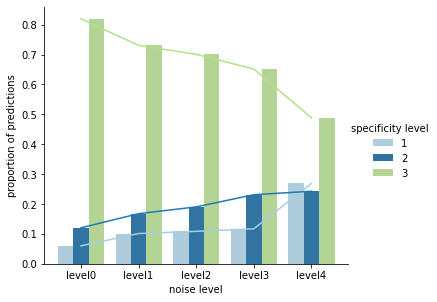

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


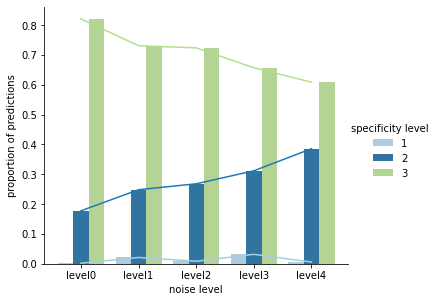

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


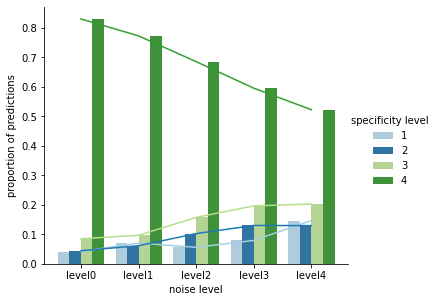

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


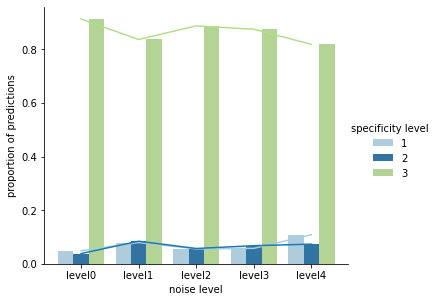

In [36]:
sns.set_style(None)
for dictionary in [aquatic, plants, animals, transport]:
  temp = (pd.DataFrame.from_dict(dictionary).T).loc[:,1:]
  temp = temp.divide(np.sum(temp, axis=1), axis=0)
  temp['noise level'] = ['level'+str(x) for x in range(5)]
  temp = pd.melt(temp, id_vars="noise level", var_name="specificity level", value_name="proportion of predictions")
  g=sns.factorplot(x='noise level', y='proportion of predictions', hue='specificity level', data=temp, kind='bar', palette=sns.color_palette("Paired"))
  mypalette = {1:color_list[0], 2:color_list[1], 3:color_list[2], 4:color_list[3]}
  g=sns.lineplot(x='noise level', y='proportion of predictions', hue='specificity level', data=temp, legend=None, palette=mypalette, markers='-o')
  plt.gcf().set_size_inches(6, 4)
  plt.show()

## Masking weights

In [30]:
output_list_dict = defaultdict(list)
target_list_dict = defaultdict(list)
p_ones_list = [0, 0.025, 0.05, 0.075, 0.1]
for p_ones in p_ones_list:
  # Get model blueprint and load from checkpoint
  model = models.__dict__['densenet'](
                      num_classes=100,
                      depth=100,
                      growthRate=12,
                      compressionRate=2,
                      dropRate=0,
                  )
  model = torch.nn.DataParallel(model).cuda()
  checkpoint = torch.load('/content/pytorch-classification/checkpoints/cifar100/densenet-bc-100-12/model_best.pth.tar')
  model.load_state_dict(checkpoint['state_dict'])

  with torch.no_grad():
    for name, param in model.named_parameters():
      if 'conv' in name:
        orig = param.data * -1
        mask = torch.tensor(np.random.binomial(n=1, p=p_ones, size=param.size())).cuda()
        orig = torch.mul(orig, mask).cuda()
        param.add_(orig)
    # Get targets and outputs
    output_list = []
    target_list = []
    softmax = Softmax(dim=1)
    model.eval()
    for batch_idx, (inputs, targets) in enumerate(testloader):
      inputs, targets = inputs.cuda(), targets.cuda()
      inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)
      # compute output
      outputs = softmax(model(inputs)).detach().cpu().numpy()
      outputs = np.argmax(outputs, axis=1)
      output_list.extend(outputs)
      target_list.extend(targets.detach().cpu().numpy())
    print('Correct out of 10000: '+str((np.array(output_list)==np.array(target_list)).sum()))
    output_list_dict[p_ones] = output_list
    target_list_dict[p_ones] = target_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Correct out of 10000: 7710
Correct out of 10000: 6646
Correct out of 10000: 5060
Correct out of 10000: 3463
Correct out of 10000: 2155


In [31]:
aquatic, plants, animals, people, transport = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)

for p_ones in p_ones_list:

  output_list = output_list_dict[p_ones]
  target_list = target_list_dict[p_ones]

  # water organisms
  small_fish = [class_names.index(x) for x in ['aquarium_fish', 'trout', 'flatfish']]
  big_fish_mammal = [class_names.index(x) for x in ['dolphin', 'whale', 'shark', 'ray']]
  aquatic_mammal = [class_names.index(x) for x in ['beaver', 'seal', 'otter']]
  all_aquatic_life = small_fish + big_fish_mammal + aquatic_mammal

  class_wrong, class_general, class_med, class_specific = 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in all_aquatic_life:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in small_fish and output_list[i] in small_fish) or \
      (target_list[i] in big_fish_mammal and output_list[i] in big_fish_mammal) or \
      (target_list[i] in aquatic_mammal and output_list[i] in aquatic_mammal):
        class_med += 1
      elif output_list[i] in all_aquatic_life:
        class_general += 1
      else:
        class_wrong += 1
  aquatic[p_ones] = [class_wrong, class_general, class_med, class_specific]

  # nonmoving living things
  flowers = [class_names.index(x) for x in ['orchid', 'poppy', 'rose', 'sunflower', 'tulip']]
  trees = [class_names.index(x+'_tree') for x in ['maple', 'oak', 'palm', 'pine', 'willow']]+[class_names.index('forest')]
  living_nonmoving = flowers + trees

  class_wrong, class_general, class_med, class_specific = 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in living_nonmoving:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in flowers and output_list[i] in flowers) or \
      (target_list[i] in trees and output_list[i] in trees):
        class_med += 1
      elif output_list[i] in living_nonmoving:
        class_general += 1
      else:
        class_wrong += 1
  plants[p_ones] = [class_wrong, class_general, class_med, class_specific]

  # moving livin things
  large_carniomni = [class_names.index(x) for x in ['bear', 'leopard', 'lion', 'tiger', 'wolf', 'fox']]
  large_herbiomni = [class_names.index(x) for x in ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']]
  small_animals = [class_names.index(x) for x in ['porcupine', 'possum', 'raccoon', 'skunk', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']]
  reptiles = [class_names.index(x) for x in ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']]
  insects = [class_names.index(x) for x in ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']]
  non_insect_invertebrates = [class_names.index(x) for x in ['crab', 'lobster', 'snail', 'spider', 'worm']]
  animals_all = large_carniomni+large_herbiomni+small_animals+reptiles
  creatures_all = insects+non_insect_invertebrates
  living_moving = animals_all+creatures_all

  class_wrong, class_general, class_med, class_subspecific, class_specific = 0, 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in living_moving:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in large_carniomni and output_list[i] in large_carniomni) or \
      (target_list[i] in large_herbiomni and output_list[i] in large_herbiomni) or \
      (target_list[i] in small_animals and output_list[i] in small_animals) or \
      (target_list[i] in reptiles and output_list[i] in reptiles) or \
      (target_list[i] in insects and output_list[i] in insects) or \
      (target_list[i] in non_insect_invertebrates and output_list[i] in non_insect_invertebrates):
        class_subspecific += 1
      elif (target_list[i] in animals_all and output_list[i] in animals_all) or \
      (target_list[i] in creatures_all and output_list[i] in creatures_all):
        class_med += 1
      elif output_list[i] in living_moving:
        class_general += 1
      else:
        class_wrong += 1
  animals[p_ones] = [class_wrong, class_general, class_med, class_subspecific, class_specific]

  # humans
  man_boy = [class_names.index(x) for x in ['man', 'woman']]
  woman_girl = [class_names.index(x) for x in ['boy', 'girl']]
  babies = [class_names.index(x) for x in ['baby']]
  humans = man_boy + woman_girl + babies

  class_wrong, class_general, class_med, class_specific = 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in humans:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in man_boy and output_list[i] in man_boy) or \
      (target_list[i] in woman_girl and output_list[i] in woman_girl) or \
      (target_list[i] in babies and output_list[i] in babies):
        class_med += 1
      elif output_list[i] in humans:
        class_general += 1
      else:
        class_wrong += 1
  people[p_ones] = [class_wrong, class_general, class_med, class_specific]

  # vehicles
  two_wheel = [class_names.index(x) for x in ['bicycle', 'motorcycle']]
  four_wheel = [class_names.index(x) for x in ['bus', 'pickup_truck', 'lawn_mower', 'tractor']]
  multi_wheel = [class_names.index(x) for x in ['train', 'streetcar', 'tank']]
  vehicles = two_wheel + four_wheel + multi_wheel

  class_wrong, class_general, class_med, class_specific = 0, 0, 0, 0
  for i in range(len(target_list)):
    if target_list[i] in vehicles:
      if target_list[i]==output_list[i]:
        class_specific +=1
      elif (target_list[i] in two_wheel and output_list[i] in two_wheel) or \
      (target_list[i] in four_wheel and output_list[i] in four_wheel) or \
      (target_list[i] in multi_wheel and output_list[i] in multi_wheel):
        class_med += 1
      elif output_list[i] in vehicles:
        class_general += 1
      else:
        class_wrong += 1
  transport[p_ones] = [class_wrong, class_general, class_med, class_specific]

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


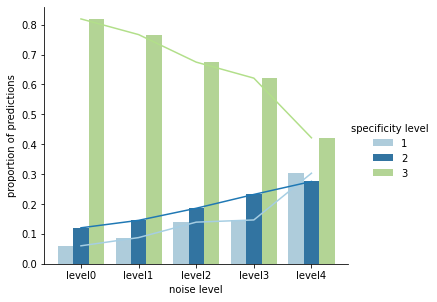

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


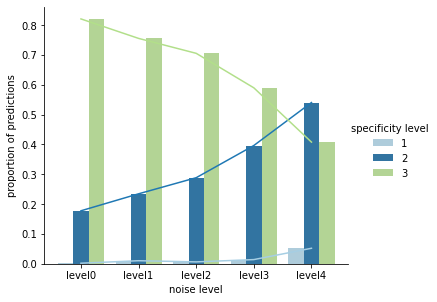

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


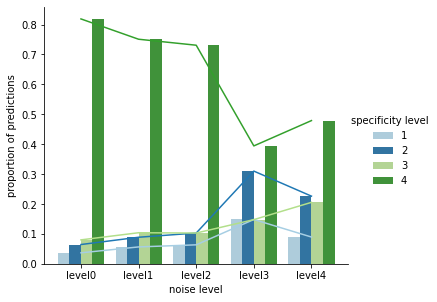

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


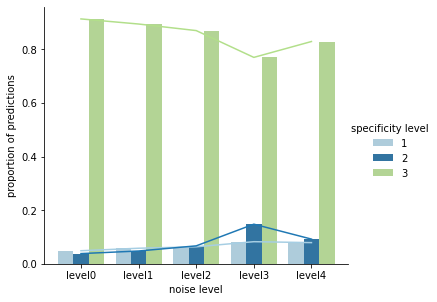

In [32]:
sns.set_style(None)
for dictionary in [aquatic, plants, animals, transport]:
  temp = (pd.DataFrame.from_dict(dictionary).T).loc[:,1:]
  temp = temp.divide(np.sum(temp, axis=1), axis=0)
  temp['noise level'] = ['level'+str(x) for x in range(0,5)]
  temp = pd.melt(temp, id_vars="noise level", var_name="specificity level", value_name="proportion of predictions")
  g=sns.factorplot(x='noise level', y='proportion of predictions', hue='specificity level', data=temp, kind='bar', palette=sns.color_palette("Paired"))
  mypalette = {1:color_list[0], 2:color_list[1], 3:color_list[2], 4:color_list[3]}
  g=sns.lineplot(x='noise level', y='proportion of predictions', hue='specificity level', data=temp, legend=None, palette=mypalette, markers='-o')
  plt.gcf().set_size_inches(6, 4)
  plt.show()